In [2]:
import pandas as pd
import numpy as np
import plotly.express as plt

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.feature_selection import SelectKBest,mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split,GridSearchCV
import sklearn.metrics as m

from joblib import dump
import missingno as mso

In [3]:
url="oil_dataset.csv"
df=pd.read_csv(url)
df

,Mendacium,Depth,Price
0,3.359,1722.533,74.048691
1,1.348,2062.571,83.321907
2,0.418,2013.507,82.748964
3,8.193,1420.607,84.760494
4,5.210,951.957,54.588671
...,...,...,...
995,1.755,247.752,51.477497
996,2.771,1609.462,73.971975
997,11.559,1943.008,123.883064
998,8.645,2250.942,116.879069


In [4]:
num_cols=["Mendacium","Depth"]

In [5]:
num_trans=Pipeline(steps=[ 
    ("scaler",StandardScaler())
])

processor=ColumnTransformer(transformers=[ 
    ("numerical",num_trans,num_cols)
])

model=Pipeline(steps=[ 
    ("preprocessed",processor),
    ("selector",SelectKBest(mutual_info_regression,k="all")),
    ("regressor",RandomForestRegressor())
])

In [6]:
model

Pipeline(steps=[('preprocessed',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Mendacium', 'Depth'])])),
                ('selector',
                 SelectKBest(k='all',
                             score_func=<function mutual_info_regression at 0x0000024EBAB82C20>)),
                ('regressor', RandomForestRegressor())])

In [7]:
x,y=df.drop("Price",axis=1),df["Price"]

In [8]:
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.2,random_state=1)

In [9]:
param_grid={
    "selector__k":[1,2],
    "regressor__max_depth":[10,51,5],
    "regressor__n_estimators":[10,51,5],
    "regressor__criterion":["absolute_error","friedman_mse","poisson","squared_error"]
}

result=GridSearchCV(model,param_grid,n_jobs=-1,verbose=1)
result.fit(xtrain,ytrain)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(estimator=Pipeline(steps=[('preprocessed',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Mendacium',
                                                                          'Depth'])])),
                                       ('selector',
                                        SelectKBest(k='all',
                                                    score_func=<function mutual_info_regression at 0x0000024EBAB82C20>)),
                                       ('regressor', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'regressor__criterion': ['absolute_error',
                                                  'friedman_mse', 'poisson',
                                                  'squared_error'],
                         'regressor__max_depth': [10, 51, 5],
                         'regressor__n_estimators': [10, 51, 5],
                         'selector__k': [1, 2]},
             verbose=1)

In [10]:
result.best_params_

{'regressor__criterion': 'absolute_error',
 'regressor__max_depth': 10,
 'regressor__n_estimators': 51,
 'selector__k': 2}

In [11]:
# model.fit(xtrain,ytrain)
# with and without gridsearchCV metrics are same

In [12]:
ypred=result.predict(xtest)

In [13]:
print("Metrics")
print(f"MAE:{m.mean_absolute_error(ytest,ypred):.2f}")
print(f"MSE:{m.mean_squared_error(ytest,ypred):.2f}")
print(f"Accuracy:{m.r2_score(ytest,ypred):.2f}")

Metrics
MAE:5.66
MSE:47.27
Accuracy:0.95


<Axes: ylabel='Density'>

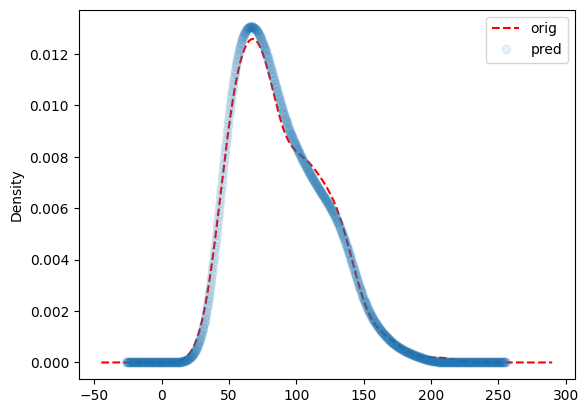

In [14]:
evaldf=pd.DataFrame([ytest.values,ypred],index=["orig","pred"]).T
ax=evaldf.plot(kind="kde",y="orig",style="r--")
evaldf.plot(kind="kde",y="pred",linewidth=6,alpha=.1,style="o",ax=ax)

In [15]:
dump(result,"oil_predictor.jb")

['oil_predictor.jb']